In [162]:
import torch 
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

from pytorch_lightning import LightningModule
import pytorch_lightning as pl
from torchdiffeq import odeint
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import networkx as nx
from utilities import *

# Defining the closed-loop kuramoto 

In [163]:
class kuramoto_angular_closed_loop(nn.Module):  

    def __init__(self,  adj_mat, coupling, n_nodes=4, natfreqs=None):
        super(kuramoto_angular_closed_loop, self).__init__()
        self.adj_mat = adj_mat
        self.coupling = coupling
        if natfreqs is not None:
            self.natfreqs = natfreqs
            self.n_nodes = len(natfreqs)
        else:
            self.n_nodes = n_nodes
            self.natfreqs = torch.randn((self.n_nodes,1))

        # Define controller parameters 
        self.act = nn.Tanh()
        self.K = nn.Parameter(torch.rand(self.n_nodes,2,2))
        self.b = nn.Parameter(torch.rand(self.n_nodes*2,1))
        self.G = nn.Parameter(torch.rand(self.n_nodes*2,1)) 
        # self.G = (1/self.n_nodes)*torch.rand(self.n_nodes*2,1)
        # self.g2 = torch.randn(2,1)
        self.J_individual = torch.tensor([[0, -1],
                               [1, 0 ,]]) 
        self.J = torch.kron(torch.eye(self.n_nodes),self.J_individual)
        self.gamma = torch.rand(1,1)

       
   
    def forward(self, t, x):


        x_int, xi = x[0:self.n_nodes*2,:].clone(), x[self.n_nodes*2:,:].clone()
        x_1, x_2 = x_int[0:self.n_nodes,:],  x_int[self.n_nodes:,:]

        assert len(x) // 4 == len(self.natfreqs) == len(self.adj_mat), \
            'Input dimensions do not match, check lengths'
       
        # Dynamics of the Kuramoto Oscillators
        angles_i, angles_j = torch.meshgrid(x_1.view(self.n_nodes), x_1.view(self.n_nodes), indexing=None)
        x_i, x_j = torch.meshgrid(x_2.view(self.n_nodes), x_2.view(self.n_nodes), indexing=None)
        g_ij = torch.cos(angles_j - angles_i)
        x_ij = x_j - x_i
        interactions = self.adj_mat * g_ij *  x_ij                  # Aij * sin(j-i)  *
        
        
        # Control Law
        G =  (10.0/self.n_nodes) * self.G.repeat(1,self.n_nodes)*torch.kron(self.adj_mat,torch.ones(2,1))
        u = self.controller_output(xi)

        dxdt = (self.coupling/self.n_nodes) * u * interactions.sum(axis=0).reshape(self.n_nodes,1) # sum over incoming interactions
        

        # Dynamics of the Hamiltonian controller
        M2 = G @ G.T 
        self.gamma = 0.5*torch.max(torch.real(torch.linalg.eigvals(M2)).detach())
        # self.gamma = 0.5
        R_idv = (self.gamma) * torch.eye(2)  # Gamma for an individual plant
        R = torch.kron(torch.eye(self.n_nodes),R_idv)
        F = self.J - R
        dxi_dt = F @ self.dH_dxi(xi) + G @ x_2
        stacked_dxdt = torch.cat((x_2, dxdt), dim=0)
        stacked_cl_loop = torch.cat((stacked_dxdt, dxi_dt), dim=0)
        return stacked_cl_loop
    
    def dH_dxi(self,xi):
        """
        Partial of the hamiltonian function of the controller. We consider the Hamiltonian to be seperated
        """
        K = torch.block_diag(*self.K)
        M = self.act(K @ xi + self.b) 
        return K.T @ M
    
    def controller_output(self,xi):
        """
        This function returns the controller output
        """
        G = self.G.repeat(1,self.n_nodes)*torch.kron(self.adj_mat,torch.ones(2,1))

        u = -G.T @ self.dH_dxi(xi)
  
        return u

# Defining the critical parameters and choosing the graph

In [164]:
Adjacency_matrix = generate_square_lattice(side_size = 8, seed=1) 
print(Adjacency_matrix.shape)
endtime = 3.0
tol = 1e-7
N_nodes = Adjacency_matrix.shape[0]

# Defining the closed-loop oscillators
natural_frequencies = torch.empty([N_nodes])\
                               .normal_(mean=0, std=0.2)


critical_coupling_constant = calculate_critical_coupling_constant(Adjacency_matrix, natural_frequencies)
coupling_constant = 0.1*critical_coupling_constant
print("the coupling constant is", coupling_constant)

torch.Size([64, 64])
the coupling constant is tensor([5.9942])


In [165]:
class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, endtime]).float()
        self.time = torch.linspace(0,endtime,int(300*endtime))

    def node_propagation(self,x): 
        out = odeint(self.odefunc, x, self.time, rtol=tol, atol=tol, method="euler")
        return out

    def forward(self,x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol, method="euler")
        return out[1]   

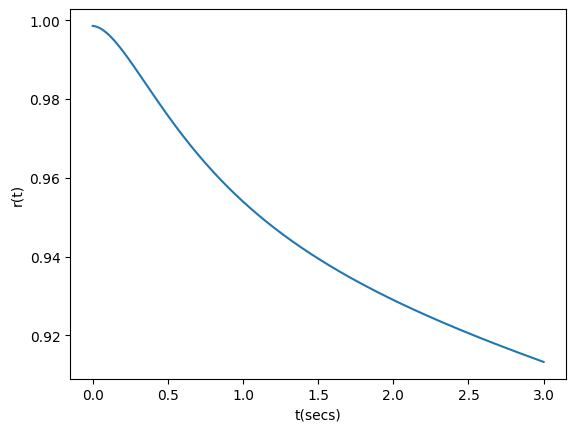

In [166]:

coupling_constant = 0.1
odefunc = kuramoto_angular_closed_loop(adj_mat= Adjacency_matrix, coupling = coupling_constant , n_nodes=N_nodes, natfreqs=natural_frequencies)



x0= torch.cat((torch.randn(N_nodes*2,1)*0.1, 
                           torch.zeros(N_nodes*2,1)), dim=0)
# for testing purposes
tol = 1e-7
endtime = 3
t = torch.linspace(0., endtime, 200*endtime)
out = odeint(odefunc, x0, t, method="euler")

out_r = out[:,N_nodes:-1].squeeze(-1)
n = out_r.shape[-1]
diff = torch.cos(out_r.unsqueeze(-1) - out_r.unsqueeze(-2))
sum_diff = (diff).sum(-1).sum(-1)
r = (1 / n) * (sum_diff ** (1 / 2))

plt.figure(1)
plt.plot(t, r.detach().numpy())
plt.ylabel('r(t)')
plt.xlabel('t(secs)')
plt.savefig("/home/mzakwan/TAC2023/Karutomo_Oscilators/r_distributed_without_train.pdf")
plt.show()

In [167]:
model = ODEBlock(odefunc)

class ImageClassifier_global(LightningModule):
        def __init__(self):
            super().__init__()
            self.save_hyperparameters()
            self.net = model
            self.adj_mat = Adjacency_matrix
            self.n_nodes = Adjacency_matrix.shape[0]
            self.reg_weight = 1e-7
            
        def forward(self,x):
            return self.net(x)
        
        def calculate_loss(self, x):
            x_i, x_j = torch.meshgrid(x.view(self.n_nodes), x.view(self.n_nodes), indexing=None)
            diff = x_j-x_i # create the difference of x_j - x_i in each row element
            sin_sqr_diff   =  torch.sin(diff)**2
            adjacency_mult = self.adj_mat*sin_sqr_diff
            loss = adjacency_mult.sum() # sum over i and j
            return loss
        

        def training_step(self, batch, batch_idx):
            
            
            # x_long = self.net.node_propagation(x0).squeeze(-1)
            # print(x_long.shape)
            # print(x_long[-1,:])
            # print(self.forward(x0).shape)
            # print(self.forward(x0))

            xloss = self.forward(x0)
            x, xi = xloss[0:self.n_nodes*2].clone(), xloss[self.n_nodes*2:].clone()
            x_2 = x[self.n_nodes:]
            u_ctrl = self.net.odefunc.controller_output(xi.reshape( self.n_nodes*2,1))
            loss_int = (1.0/self.n_nodes)*self.calculate_loss(x_2) + (0.5)*self.reg_weight*torch.norm(u_ctrl,2)
            loss = loss_int
            # print(x.shape)
            # x_2 = x[self.n_nodes:]
            # loss_int = (1.0/self.n_nodes)*self.calculate_loss(x_2)


            # cumm_loss = 0.0
            # for idx in range(0,x_long.shape[0]):
            #     xloss = x_long[idx,:]
            #     x, xi = xloss[0:self.n_nodes*2].clone(), xloss[self.n_nodes*2:].clone()
            #     print(x.shape)
            #     x_2 = x[self.n_nodes:]
            #     u_ctrl = self.net.odefunc.controller_output(xi.reshape( self.n_nodes*2,1))
            #     loss_int = (1.0/self.n_nodes)*self.calculate_loss(x_2) + (0.5/self.n_nodes)*self.reg_weight*torch.norm(u_ctrl,2)
            #     cumm_loss += loss_int
            
            # loss = cumm_loss.mean() 
            # loss = 0
            self.log("total_loss", loss, prog_bar=True)

            return loss
            

        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-2, eps=1e-3, amsgrad=True)
            return optimizer

In [168]:
class TrainDataset(Dataset):
    def __init__(self, q_range, p_range):

        grid_q, grid_p = torch.meshgrid(
            q_range, p_range)

        self.q_data = grid_q.reshape(-1,)
        self.p_data = grid_p.reshape(-1,)

    def __len__(self):
        return len(self.q_data)

    def __getitem__(self, idx):

        return self.q_data[idx], self.p_data[idx]
    

training_data = TrainDataset(
        torch.linspace(1/4-2, 1/4+2, 1), torch.linspace(-2, 2, 1))

train_dataloader = DataLoader(
    training_data, batch_size=1, num_workers=30, persistent_workers=True)


torch.set_float32_matmul_precision('medium')
    

#Defining the logger 
model_ode = ImageClassifier_global()

trainer = pl.Trainer(
    max_epochs=2000,
    accelerator='cpu',
    num_nodes=1,
)

trainer.fit(model_ode, train_dataloader)
trainer.save_checkpoint(
        "/home/mzakwan/TAC2023/Karutomo_Oscilators/test_lightning_model.ckpt")
time.sleep(5)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
/home/mzakwan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=4)`.
  rank_zero_warn(

  | Name | Type     | Params
----------------------------------
0 | net  | ODEBlock | 512   
----------------------------------
512       Trainable params
0         Non-trainable params
512       Total params
0.002     Total estimated model params size (MB)
/home/mzakwan/.local/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


## Simulations

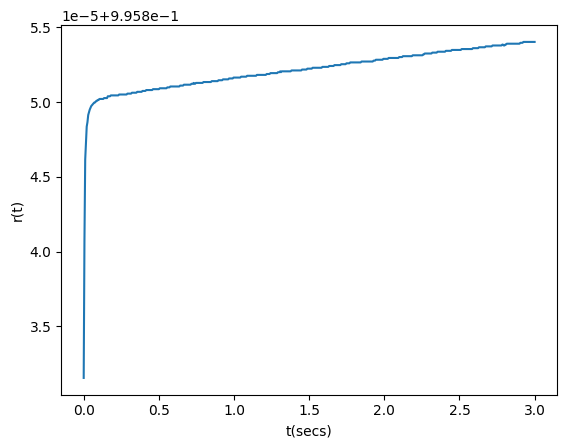

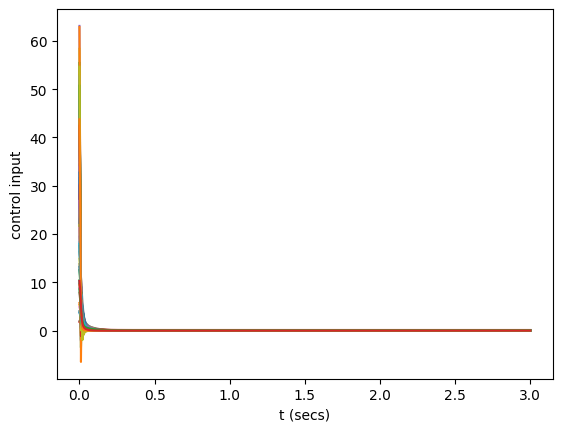

In [169]:
endtime = 3.0
endtime = endtime 

t = torch.linspace(0., endtime, int(200*endtime))
out = odeint(odefunc, x0, t, method="euler")

out = out.squeeze(-1)
x, out_ctrl = out[:,0:N_nodes*2].clone(), out[:, N_nodes*2:].clone()
out_r = x[:, N_nodes:]
    
u_ctrl = model.odefunc.controller_output(out_ctrl.T)
# print(u_ctrl.shape)
n = out_r.shape[-1]
diff = torch.cos(out_r.unsqueeze(-1) - out_r.unsqueeze(-2))
sum_diff = (diff).sum(-1).sum(-1)
r = (1 / n) * (sum_diff ** (1 / 2))

plt.figure(2)
plt.plot(t, r.detach().numpy())
plt.ylabel('r(t)')
plt.xlabel('t(secs)')
plt.savefig("/home/mzakwan/TAC2023/Karutomo_Oscilators/r_closed_loop_distributed.pdf")

plt.figure(3)
plt.plot(t,-u_ctrl.T.detach().numpy())
plt.ylabel('control input')
plt.xlabel('t (secs)')
plt.savefig("/home/mzakwan/TAC2023/Karutomo_Oscilators/u_closed_loop_distributed.pdf")